## PART 1:

(60000, 784)
(10000, 784)
Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6922 - val_loss: 0.6921
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6920 - val_loss: 0.6919
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6915 - val_loss: 0.6913
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6913 - val_loss: 0.6911
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6911 - val_loss: 0.6909
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss:

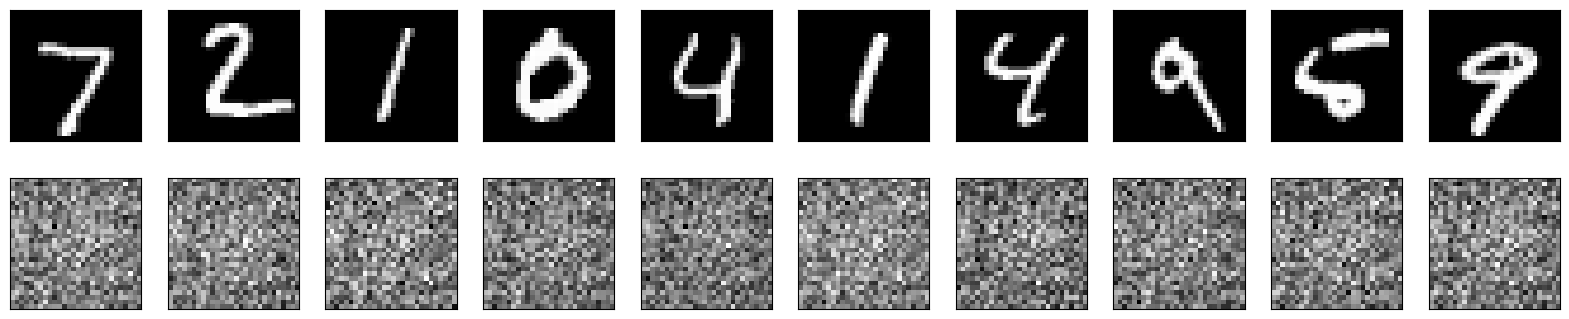

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Top 10 Reconstruction Errors:
383.5003
383.20132
381.39
381.3134
380.79474
380.54816
380.10907
380.06824
379.6429
379.45398


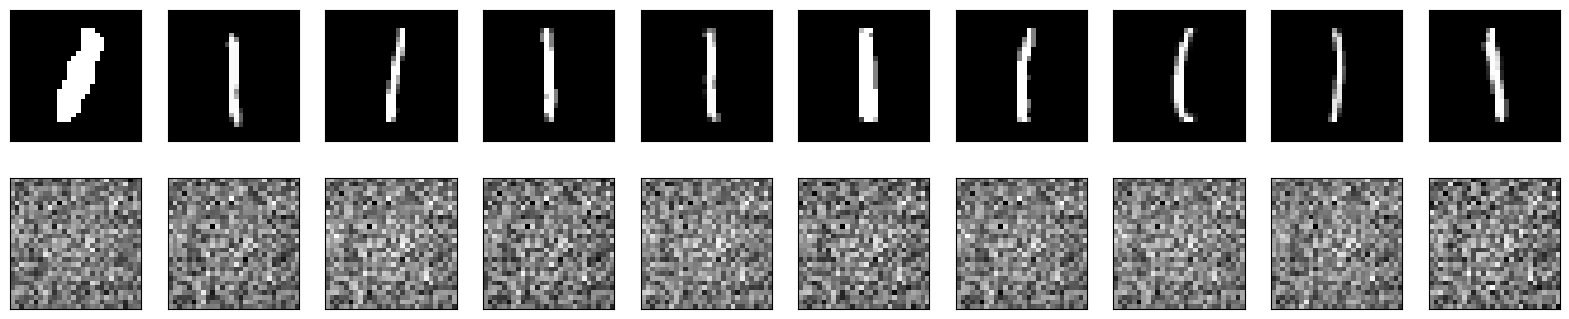

In [2]:
diffs = np.sum(np.abs(x_test - decoded_imgs), axis=1)
sort_idxs = np.argsort(-diffs)
sort_diffs = sorted(diffs, reverse=True)
top10_diffs = sort_diffs[:10]

print("Top 10 Reconstruction Errors:")
for diff in top10_diffs:
    print(diff)

plt.figure(figsize=(20, 4))
for i in range(10):
    idx = sort_idxs[i]
    
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i + 11) 
    plt.imshow(decoded_imgs[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

plt.show()

## PART 2:

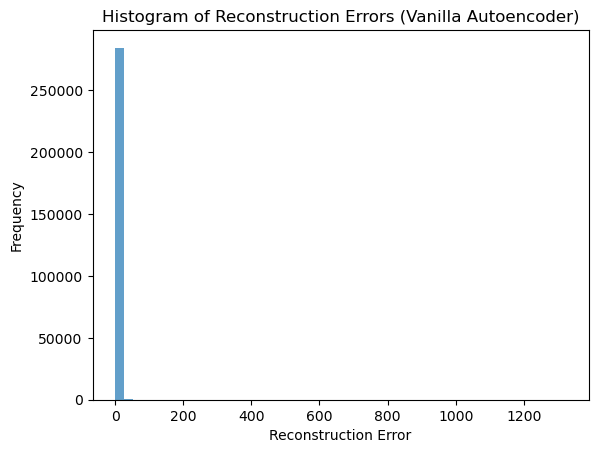

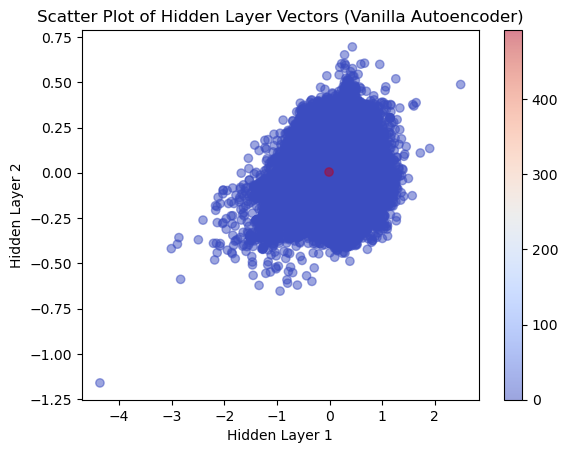

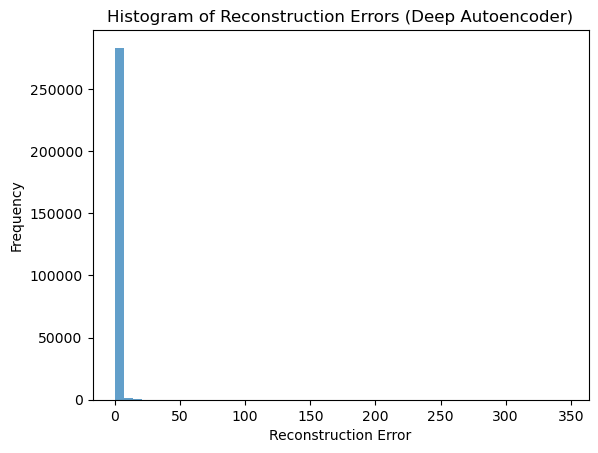

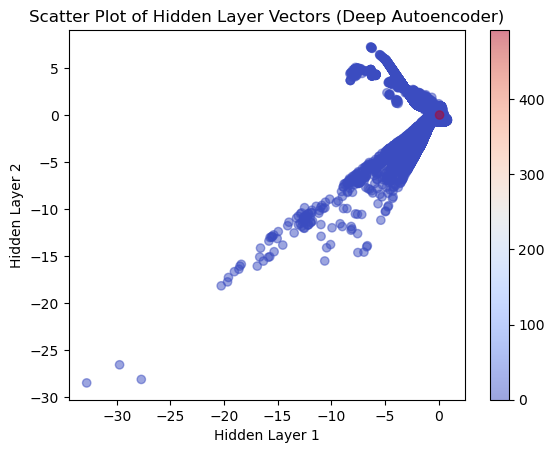

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

def train_autoencoder(X, hidden_layer_sizes, activation, solver, max_iter):
    scaler = StandardScaler()
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    X_scaled = scaler.fit_transform(X_imputed)
    
    autoencoder = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )
    
    autoencoder.fit(X_scaled, X_scaled)
    
    reconstruction_errors = np.mean(np.square(X_scaled - autoencoder.predict(X_scaled)), axis=1)
    
    # Use the predict method to obtain the hidden layer vectors
    hidden_layer_vectors = autoencoder.predict(X_scaled)
    
    return reconstruction_errors, hidden_layer_vectors

def plot_histogram(errors, title):
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.show()

def plot_scatter(hidden_layer_vectors, class_labels, title):
    plt.scatter(hidden_layer_vectors[:, 0], hidden_layer_vectors[:, 1], c=class_labels, cmap='coolwarm', alpha=0.5)
    plt.title(title)
    plt.xlabel('Hidden Layer 1')
    plt.ylabel('Hidden Layer 2')
    plt.colorbar()
    plt.show()

# Load your data into a DataFrame named 'df'
df = pd.read_csv('Downloads/data1.csv')

# Extract the first 28 columns for input
X = df.iloc[:, :28].values
class_labels = df['Class'].values

# Step 1: Vanilla Autoencoder
errors_vanilla, hidden_layer_vectors_vanilla = train_autoencoder(X, (2,), 'identity', 'adam', 1000)
plot_histogram(errors_vanilla, 'Histogram of Reconstruction Errors (Vanilla Autoencoder)')
plot_scatter(hidden_layer_vectors_vanilla, class_labels, 'Scatter Plot of Hidden Layer Vectors (Vanilla Autoencoder)')

# Step 2: Deep Autoencoder
errors_deep, hidden_layer_vectors_deep = train_autoencoder(X, (20, 2, 20), 'relu', 'adam', 1000)
plot_histogram(errors_deep, 'Histogram of Reconstruction Errors (Deep Autoencoder)')
plot_scatter(hidden_layer_vectors_deep, class_labels, 'Scatter Plot of Hidden Layer Vectors (Deep Autoencoder)')


## PART 3:

Epoch 1/30
469/469 [==============================] - 39s 82ms/step - loss: 204.6440 - reconstruction_loss: 202.5648 - kl_loss: 2.0793
Epoch 2/30
469/469 [==============================] - 42s 89ms/step - loss: 164.0058 - reconstruction_loss: 161.0339 - kl_loss: 2.9719
Epoch 3/30
469/469 [==============================] - 42s 89ms/step - loss: 156.6837 - reconstruction_loss: 153.4606 - kl_loss: 3.2231
Epoch 4/30
469/469 [==============================] - 38s 81ms/step - loss: 153.6901 - reconstruction_loss: 150.3337 - kl_loss: 3.3564
Epoch 5/30
469/469 [==============================] - 39s 83ms/step - loss: 151.8513 - reconstruction_loss: 148.4202 - kl_loss: 3.4311
Epoch 6/30
469/469 [==============================] - 39s 82ms/step - loss: 150.5109 - reconstruction_loss: 147.0165 - kl_loss: 3.4944
Epoch 7/30
469/469 [==============================] - 38s 82ms/step - loss: 149.4166 - reconstruction_loss: 145.8665 - kl_loss: 3.5501
Epoch 8/30
469/469 [==============================] - 3

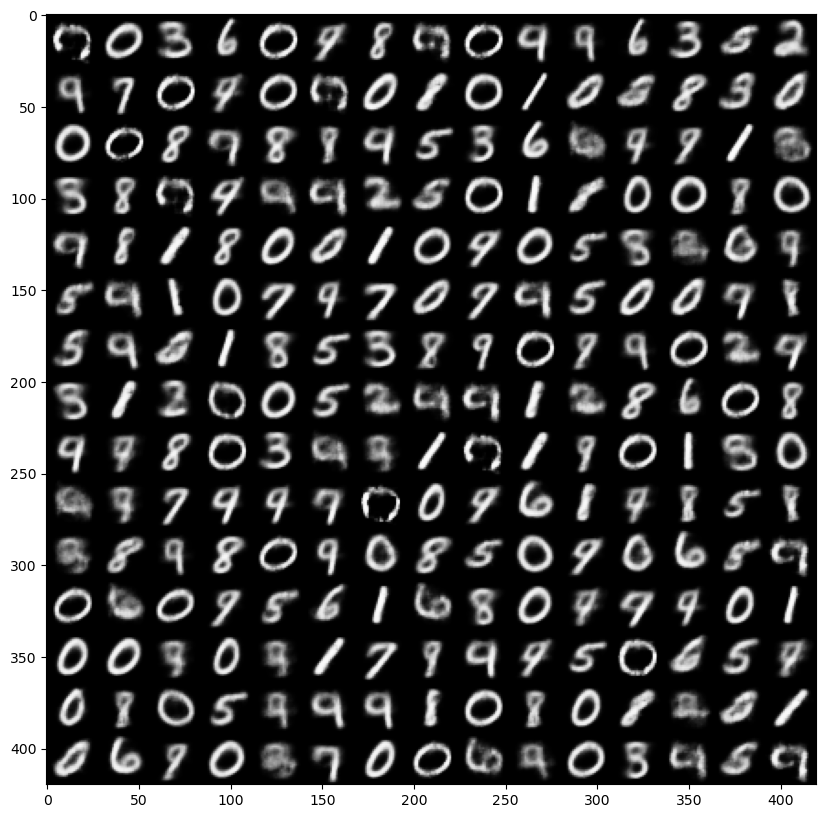

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf

# Load MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Define the VAE model
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)  # Additional layer with dimension 64
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = Model(encoder_inputs, [z_mean, z_log_var])

decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(decoder_inputs)  # Additional layer with dimension 64
x = layers.Dense(7 * 7 * 64, activation="relu")(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = Model(decoder_inputs, decoder_outputs)

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling((z_mean, z_log_var))
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Train the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

# Plot newly generated images
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.array([[np.random.normal(), np.random.normal()]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()
